In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_banded

### Initial Conditions

In [6]:
S0 = 100
S_max = 500 # maximum stock price
K = 100 #strike
T = 1 #expiration
r = 0.05 #interest rate 
sigma = 0.20 #constant vol
N =200 #number of spatial steps
M = 100000 #number of time steps
#N_values = [12, 52, 252, 500] #spatial step discretizations
M_values = np.linspace(1500, 20000, 10, dtype = int).tolist()
N_values = np.linspace(10, 600, 10, dtype = int).tolist()
#M_values = [11000, 12000, 14000, 16000, 18000] #time step discretizations

# BSM Formula Call Price & Greeks 

The price of a call option and its delta, gamma, and theta using the Black Scholes PDE is as below: 

$$d_+ = \frac{1}{\sigma \sqrt{t}} (\ln\frac{S_t}{K} + (r+\frac{\sigma^2}{2})t) , \quad d_- = d_+ - \sigma \sqrt{t}$$

$$Price= N(d_+)S_t-N(d_-)Ke^{-rt}$$

$$\frac{\partial V}{\partial S} = \Delta = N(d_+)$$

$$ \frac{\partial ^2 V}{\partial S^2} = \Gamma = \frac{N^{'}(d_+)}{S \sigma \sqrt{T}} $$

$$\frac{\partial V}{\partial t} = \theta = -\frac{SN^{'}(d_+) \sigma}{2 \sqrt{T}}-rKe^{-rT}N(d_-)$$ 

We will write a function to calculate the call option price and greeks:

In [7]:
def analytical_call(S0, sigma, T, K, r):
    N = norm.cdf
    dplus = (1 / sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + (sigma ** 2 / 2)) * (T))
    dminus = dplus - sigma * np.sqrt(T)
    
    price = N(dplus) * S0 - N(dminus) * K * np.exp(-r * (T))
    
    delta = N(dplus)
    
    gamma = norm.pdf(dplus, 0, 1)/(S0*sigma*np.sqrt(T))
    
    theta = (-S0 * norm.pdf(dplus, 0, 1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(dminus, 0, 1))
    
    return price, delta, gamma, theta
price, delta, gamma, theta = analytical_call(S0, sigma, T, K, r)

print("Price at inception:", price)
print("Delta at inception:", delta)
print("Gamma at inception:", gamma)
print("Theta at inception:", theta)

Price at inception: 10.450583572185572
Delta at inception: 0.6368306511756191
Gamma at inception: 0.018762017345846895
Theta at inception: -6.414027546438197


## Forward Price and Greeks

The value of a forward contract at inception is given by the formula:

$$ V_0 = E^{Q}[\text{Payoff of Forward}] e^{-rT} = E^{Q}[S_T - K] e^{-rT}, $$

where:

- **$V_0 $:** Initial value of the forward contract.
- **$ E^{Q} $:** Expectation under the risk-neutral measure $ Q $.
- **$S_T $:** Spot price of the underlying asset at maturity time $ T $.
- **$ K $:** Agreed-upon forward price.
- **$ e^{-rT} $:** Discount factor (where $ r $ is the risk-free interest rate and $ T $ is the time to maturity).

Given the following values:

- **$ K = 100 $:** Strike price,
- **$ S_0 = 100 $:** Initial spot price,
- **$ r = 0.05 $:** Risk-free interest rate (5%),
- **$ T = 1 \text{ year} $:** Time to maturity,

we can calculate the value of the forward contract at inception.

The forward price $ K $ should be set so that the expected value of the payoff is zero:

$$ 0 = E^{Q}[S_T - K] e^{-rT}. $$

Simplifying the equation gives:

$$ K = E^{Q}[S_T]. $$

If the underlying asset follows a geometric Brownian motion under the risk-neutral measure, the expected future spot price is:

$$ E^{Q}[S_T] = S_0 e^{rT}. $$

Plugging in the values provided:

$$ K = 100 \cdot (1 + 0.05) = 105. $$

Therefore, the forward price is:

$$ K = S_0 e^{rT} = 100 \cdot 1.05 = 105. $$

The value of the forward contract at inception is:

$$ V_0 = S_0 e^{rT} - K = 100 \cdot 1.05 - 100 = 5.0. $$

Thus, the value of the forward contract is **5.0**.

#### Delta ($\Delta$)

Delta measures the sensitivity of the value of the forward to changes in the spot price at time $ t $:

$$ \Delta = \frac{\partial V_t}{\partial S_t}. $$

Since $ S_t $ appears linearly in the value formula:

$$ \Delta = \frac{\partial (S_t - Ke^{-r(T - t)})}{\partial S_t} = 1. $$

#### Gamma ($\Gamma$)

Gamma is given by:

$$ \Gamma = \frac{\partial \Delta}{\partial S_t}. $$

Since delta is constant (1) and does not depend on $ S_t $:

$$ \Gamma = \frac{\partial 1}{\partial S_t} = 0. $$

#### Theta ($\Theta$)

Theta is calculated by:

$$ \Theta = \frac{\partial V_t}{\partial t}. $$

Differentiating the value formula with respect to time $ t $:

$$ \Theta = \frac{\partial (S_t - Ke^{-r(T - t)})}{\partial t}. $$

Breaking down the expression:

1. The derivative of $ S_t $ with respect to time $ t $ is generally zero because $ S_t $ is the current spot price at time $ t $.
2. The derivative of the discount factor is:

$$ \frac{\partial (-Ke^{-r(T - t)})}{\partial t} = K \cdot r \cdot e^{-r(T - t)}. $$

So:

$$ \Theta = K \cdot r \cdot e^{-r(T - t)}. $$

#### Summary of the Greeks:

1. **Delta:** $ \Delta = 1 $.
2. **Gamma:** $ \Gamma = 0 $.
3. **Theta:** $ \Theta = K \cdot r \cdot e^{-r(T - t)} $.


In [8]:
def analytical_forward(S0, T, K, r):
    forward_price = S0 * np.exp(r * T)
    
    price = forward_price - K
    
    delta = np.exp(r * T)
    
    gamma = 0
    
    theta = -K * r * np.exp(-r * T)
    
    return price, delta, gamma, theta

price, delta, gamma, theta = analytical_forward(S0, T, K, r)

print("Price at inception:", price)
print("Delta at inception:", delta)
print("Gamma at inception:", gamma)
print("Theta at inception:", theta)

Price at inception: 5.127109637602416
Delta at inception: 1.0512710963760241
Gamma at inception: 0
Theta at inception: -4.75614712250357


# Using an Explicit Schema to Calculate Call Price and Greeks

The Black-Scholes equation without dividends is written as:

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

Where:

- \(V\) is the option price as a function of stock price \(S\) and time \(t\),
- \(\sigma\) is the known volatility,
- \(r\) is the known risk-free rate, and
- \(S\) is the stock price.

The stock price \(S\) and time \(t\) are discretized. Let \(\Delta S\) and \(\Delta t\) denote the increments in stock price and time, respectively, and let \(i\) and \(j\) index the grid points in space and time, so that \(S_i = i \Delta S \) and \(t_j = j \Delta t\).

### Finite Difference Approximations

The derivatives in the PDE can be approximated as follows:

**First Derivative in Stock Price (Delta, $\Delta$ ):**

$$\frac{\partial V}{\partial S} \bigg|_{i,j} \approx \frac{V_{i+1, j} - V_{i-1, j}}{2 \Delta S}$$

**Second Derivative in Stock Price (Gamma, $\Gamma$ ):**

$$\frac{\partial^2 V}{\partial S^2} \bigg|_{i,j} \approx \frac{V_{i+1, j} - 2V_{i, j} + V_{i-1, j}}{(\Delta S)^2}$$

**First Derivative in Time (Theta, $\Theta$):**

$$\frac{\partial V}{\partial t} \bigg|_{i,j} \approx \frac{V_{i, j+1} - V_{i, j}}{\Delta t}$$

### Vectorized Explicit Finite Difference

In the vectorized implementation, the method updates the values of \(V\) for all spatial grid points simultaneously for each time step, using vector operations as follows:

$$
V_{i, j} = V_{i, j+1} + \Delta t \left( \frac{1}{2} \sigma^2 S_i^2 \Gamma + r S_i \Delta - r V_{i, j+1} \right)
$$

Where:
- $\Gamma$ is the vector of second derivatives of $V$ with respect to $S$ calculated across all spatial grid points.
- $\Delta$ is the vector of first derivatives of $V$with respect to $S$ calculated across all spatial grid points.

### Stability Conditions

For stability, the explicit method requires that the time step $\Delta t$ be small, satisfying:

$$
\Delta t \leq \frac{1}{\frac{\sigma^2}{\Delta S^2} + \frac{r}{\Delta S} + \frac{r}{2}}
$$

### Code Implementation of the Explicit Schema

In [9]:
def explicit_fd(S_max, K, T, r, sigma, N, M):
    Delta_S = S_max / N
    Delta_t = T / M

    stability_limit = 1 / (r + sigma**2 / Delta_S**2 + 2 * r * S_max / Delta_S)
    if Delta_t > stability_limit:
        raise ValueError(f"Unstable parameters chosen. Delta t must be <= {stability_limit:.5f}")

    S = np.linspace(0, S_max, N+1)
    V = np.zeros((N+1, M+1))

    # Boundary conditions
    V[:, M] = np.maximum(S - K, 0)
    V[0, :] = 0
    V[N, :] = np.maximum(S_max - K * np.exp(-r * (T - np.linspace(0, T, M+1))), 0)

    # Vectorize over time steps
    for j in range(M-1, -1, -1):
        deltas = (V[2:, j+1] - V[:-2, j+1]) / (2 * Delta_S)
        gammas = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (Delta_S**2)
        thetas = (V[1:-1, j+1] - V[1:-1, j]) / Delta_t
        V[1:-1, j] = V[1:-1, j+1] + Delta_t * (0.5 * sigma**2 * S[1:-1]**2 * gammas +
            r * S[1:-1] * deltas - r * V[1:-1, j+1])

    index_at_K = np.searchsorted(S, K)
    price_at_inception = V[index_at_K, 0]
    delta_at_inception = (V[index_at_K + 1, 0] - V[index_at_K - 1, 0]) / (2 * Delta_S)
    gamma_at_inception = (V[index_at_K + 1, 0] - 2 * V[index_at_K, 0] + V[index_at_K - 1, 0]) / (Delta_S**2)
    theta_at_inception = (V[index_at_K, 1] - V[index_at_K, 0]) / (Delta_t)
    return price_at_inception, delta_at_inception, gamma_at_inception, theta_at_inception


eprice, edelta, egamma, etheta = explicit_fd(S_max, K, T, r, sigma, N, M)
print("Price at inception:", eprice)
print("Delta at inception:", edelta)
print("Gamma at inception:", egamma)
print("Theta at inception:", etheta)

Price at inception: 10.43511188612049
Delta at inception: 0.6364394585752897
Gamma at inception: 0.01880756819917508
Theta at inception: -6.421976441295384


### Plotting Explicit Schema Values for Different  Spatial Step Discretizations

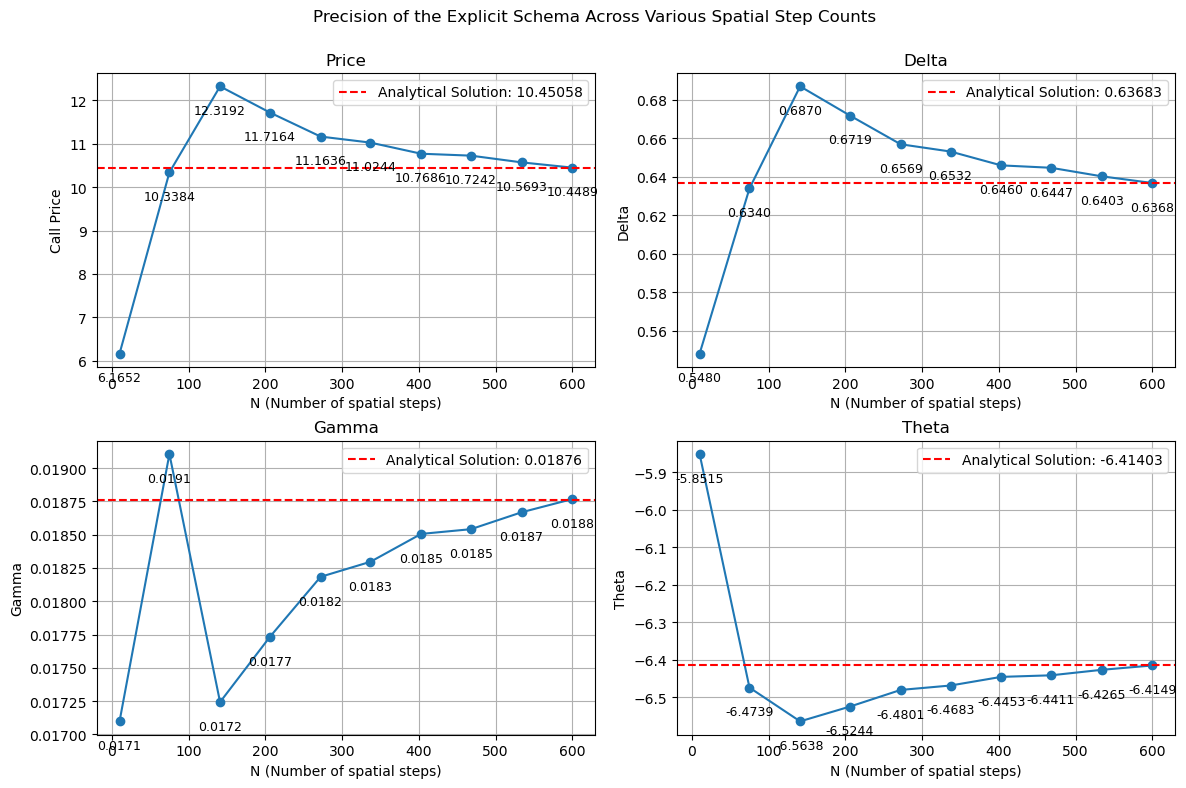

In [10]:

results = []
for N in N_values:
    results.append(explicit_fd(S_max, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']
analytical_values = analytical_call(S0, sigma, T, K, r)
plt.figure(figsize=(12, 8))
for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(N_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of spatial steps)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid()
    ax.legend()
    for x, y in zip(N_values, dataset):
        ax.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,-20), ha='center', fontsize=9)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Precision of the Explicit Schema Across Various Spatial Step Counts")
plt.show()


### Plotting Explicit Schema Values for Different  Time Step Discretizations

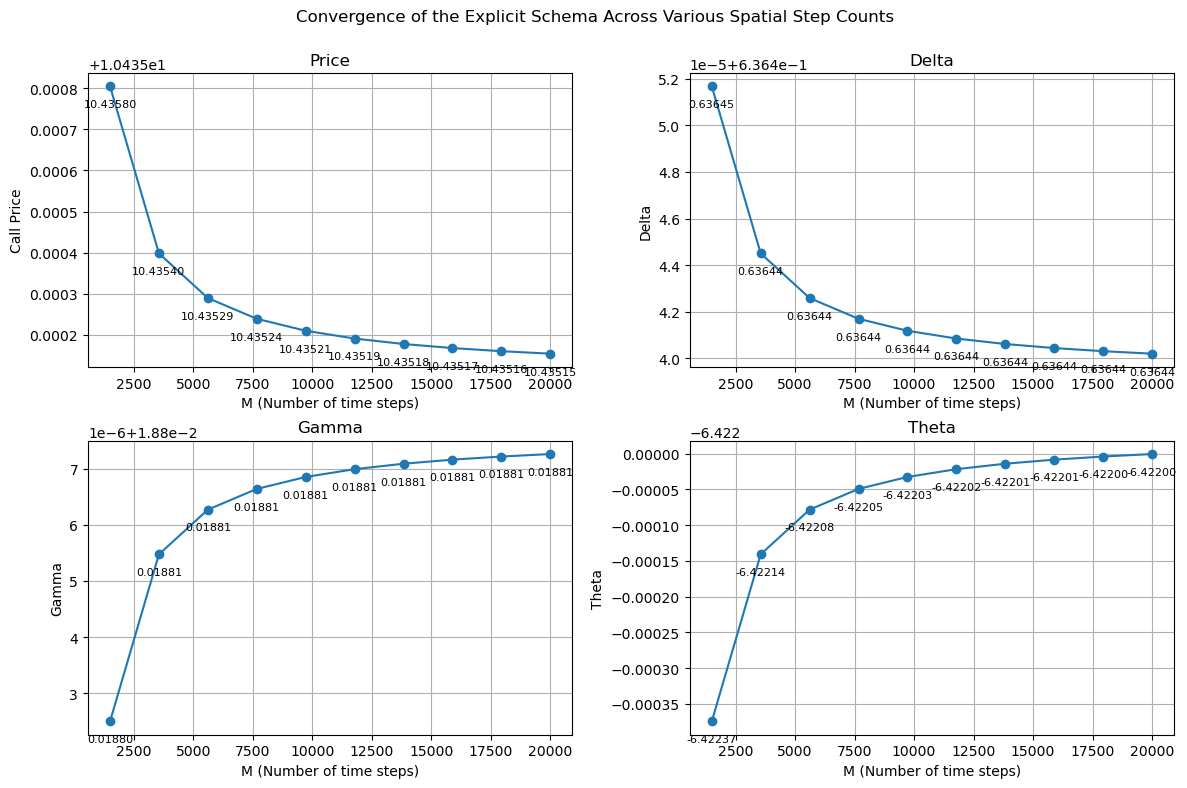

In [11]:
N = 200
results = []

for M in M_values:
    results.append(explicit_fd(S_max, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

plt.figure(figsize=(12, 8))
for i, (title, dataset, y_label) in enumerate(zip(titles, data, y_labels), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(M_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('M (Number of time steps)')
    ax.set_ylabel(y_label)
    ax.grid()
    for x, y in zip(M_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Convergence of the Explicit Schema Across Various Spatial Step Counts")
plt.show()


# Using an Implicit Schema to Calculate Call Price and Greeks

#### Finite Difference Approximations
In the implicit method, the derivatives are approximated at the new time step $j$ , as follows:

First Derivative in Stock Price (Delta, $\Delta$):
$$
\frac{\partial V}{\partial S} \approx \frac{V_{i+1, j} - V_{i-1, j}}{2 \Delta S}
$$

Second Derivative in Stock Price (Gamma, $\Gamma$):
$$
\frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1, j} - 2V_{i, j} + V_{i-1, j}}{(\Delta S)^2}
$$

First Derivative in Time (Theta, $\Theta$ ):
$$
\frac{\partial V}{\partial t}  \approx \frac{V_{i, j} - V_{i, j-1}}{\Delta t}
$$

#### Implicit Finite Difference 

The implicit scheme updates $V$ by solving the following linear system at each time step $j$ from $j = M$ down to $0$: <br>
$$
-V_{i-1, j} \left(\frac{\sigma^2 i^2 \Delta t}{2} - \frac{r i \Delta t}{2}\right) + V_{i, j} \left(1 + r \Delta t + \sigma^2 i^2 \Delta t\right) - V_{i+1, j} \left(\frac{\sigma^2 i^2 \Delta t}{2} + \frac{r i \Delta t}{2}\right) = V_{i, j+1}
$$

#### Boundary Conditions

At $S = 0$, the call option value is 0. <br>
At $S = S_{\text{max}} $, the call option value should asymptotically approach $S - K e^{-r(T - t)}$.
At maturity $t = T$, $V(S, T) = max(S - K, 0)$.


### Code Implementation of the Implicit Schema

In [12]:
def implicit_fd(S_max, K, T, r, sigma, N, M):
    Delta_S = S_max / N
    Delta_t = T / M
    S = np.linspace(0, S_max, N+1)
    V = np.zeros((N+1, M+1))

    # Boundary conditions
    V[:, M] = np.maximum(S - K, 0)
    a = np.zeros(N+1)
    b = np.zeros(N+1)
    c = np.zeros(N+1)

    for i in range(1, N):
        a[i] = 0.5 * Delta_t * (sigma**2 * i**2 - r * i)
        b[i] = -(1 + Delta_t * (sigma**2 * i**2 + r))
        c[i] = 0.5 * Delta_t * (sigma**2 * i**2 + r * i)

    for j in range(M-1, -1, -1):
        d = -V[1:N, j+1]
        d[0] -= a[1] * V[0, j+1]  # Lower boundary
        d[-2] -= c[N-1] * V[N, j+1]  # Upper boundary
        ab = np.vstack((np.hstack([0, c[1:N-1]]), b[1:N], np.hstack([a[2:N], 0])))
        V[1:N, j] = solve_banded((1, 1), ab, d)
        V[0, j] = 0
        V[N, j] = S_max - K * np.exp(-r * (T - j * Delta_t))

    index_at_100 = np.searchsorted(S, 100)
    price_at_inception = V[index_at_100, 0]
    delta_at_inception = (V[index_at_100 + 1, 0] - V[index_at_100 - 1, 0]) / (2 * Delta_S)
    gamma_at_inception = (V[index_at_100 + 1, 0] - 2 * V[index_at_100, 0] + V[index_at_100 - 1, 0]) / (Delta_S**2)
    theta_at_inception = (V[index_at_100, 1] - V[index_at_100, 0]) / (Delta_t)

    return price_at_inception, delta_at_inception, gamma_at_inception, theta_at_inception


iprice, idelta, igamma, itheta = implicit_fd(S_max, K, T, r, sigma, N, M)
print("Price at inception:", iprice)
print("Delta at inception:", idelta)
print("Gamma at inception:", igamma)
print("Theta at inception:", itheta)


Price at inception: 10.435048577495467
Delta at inception: 0.6364383427287266
Gamma at inception: 0.018808031588728225
Theta at inception: -6.422045602505477


## Plotting Implicit Schema Values for Different  Spatial Step Discretizations

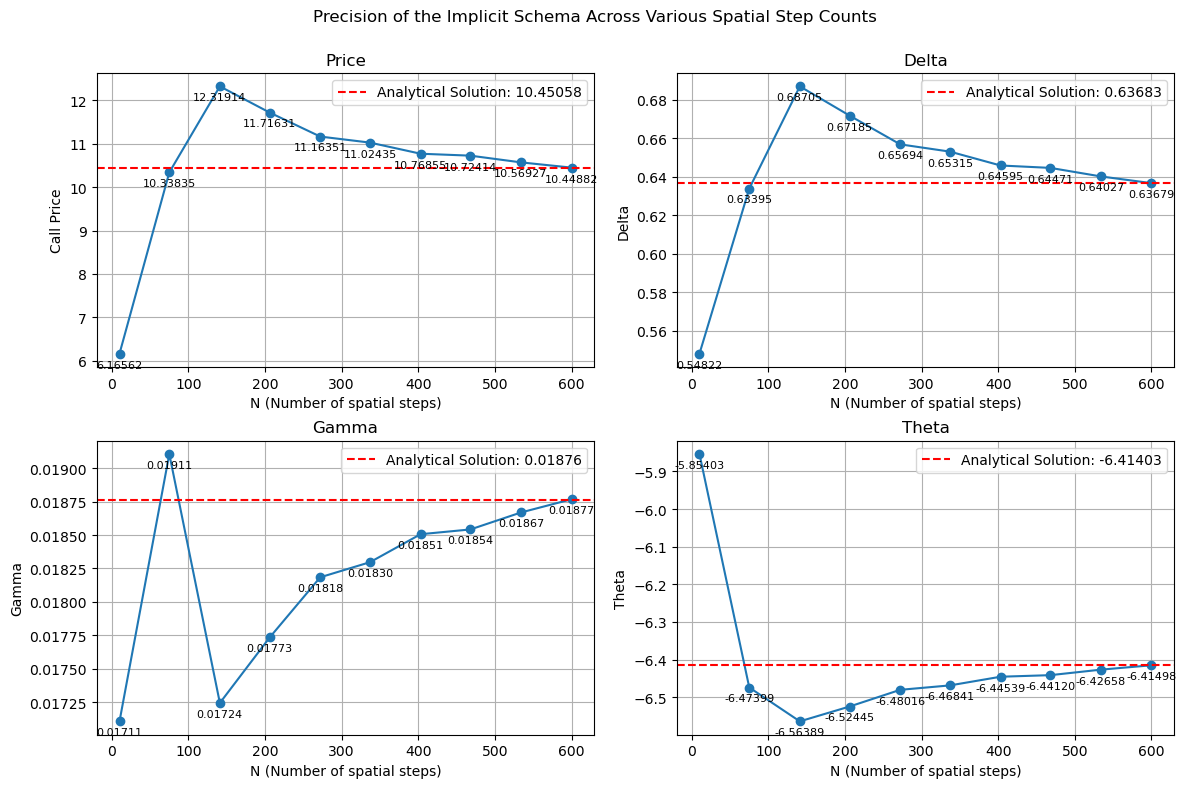

In [13]:
results = []
for N in N_values:
    results.append(implicit_fd(S_max, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

# Plotting
plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(N_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of spatial steps)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    ax.legend()
    for x, y in zip(N_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=8)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Precision of the Implicit Schema Across Various Spatial Step Counts")
plt.show()


## Plotting Implicit Schema Values for Different Time Step Discretizations

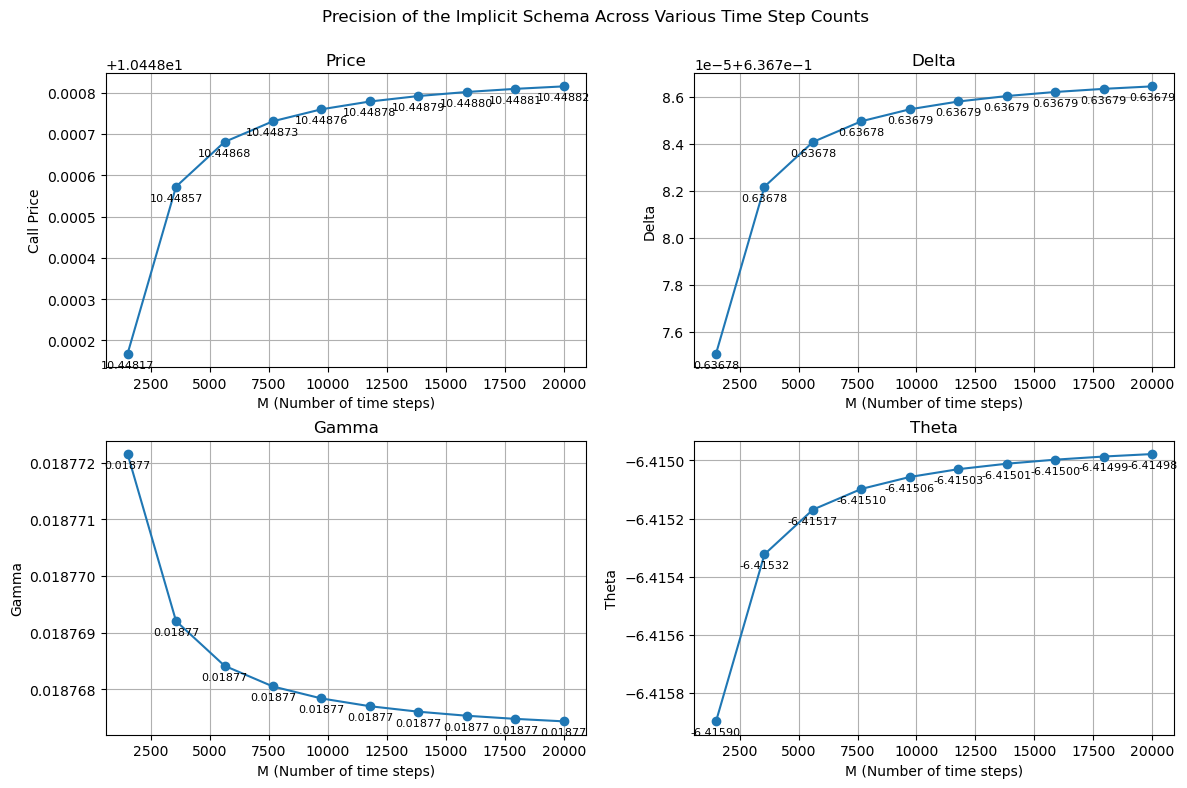

In [14]:
#M_values = [2000, 4000, 7000, 9000, 11000, 20000] #time step discretizationsresults = []
#M_values = np.linspace(1000, 10000, 8, dtype=int).tolist()
results = []
for M in M_values:
    results.append(implicit_fd(S_max, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)
plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label) in enumerate(zip(titles, data, y_labels), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(M_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('M (Number of time steps)')
    ax.set_ylabel(y_label)
    ax.grid(True)
    for x, y in zip(M_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Precision of the Implicit Schema Across Various Time Step Counts")
plt.show()


## Exercise 1.3 - Using the Crank-Nicolson to Calculate Call Price and Greeks

#### Finite Difference Approximations
The derivatives in the Black-Scholes PDE are approximated as follows, averaged between time steps $j$ and $j+1$ for the Crank-Nicolson method:

First Derivative in Stock Price (Delta, $\Delta$):
$$
\frac{\partial V}{\partial S} \approx \frac{V_{i+1, j+1} - V_{i-1, j+1}}{2 \Delta S}
$$

Second Derivative in Stock Price (Gamma, $\Gamma$):
$$
\frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1, j+1} - 2V_{i, j+1} + V_{i-1, j+1}}{(\Delta S)^2}
$$

First Derivative in Time (Theta, $\Theta$):
$$
\frac{\partial V}{\partial t} \approx \frac{V_{i, j+1} - V_{i, j}}{\Delta t}
$$

#### Crank-Nicolson Finite Difference Scheme
The Crank-Nicolson method updates $V$ using a weighted average of the implicit and explicit methods. The update equation at each grid point $(i, j)$ is given by:
$$
\frac{V_{i, j+1} - V_{i, j}}{\Delta t} + \frac{1}{2} \left( L(V^j) + L(V^{j+1}) \right) = 0
$$
where $L$ represents the differential operator applied to $V$:
$$
L(V^j) = \frac{1}{2} \sigma^2 S_i^2 \frac{\partial^2 V}{\partial S^2} + r S_i \frac{\partial V}{\partial S} - r V_{i, j}
$$

#### Boundary Conditions
Essential boundary conditions for accuracy:
- At $S = 0$, the option value is $0$.
- At $S = S_{max}$, the option value approximates $S - K e^{-r(T - t)}$.
- At maturity $t = T$, $V(S, T) = \max(S - K, 0)$.


### Code Implementation of the Crank Nicolson Schema

In [15]:
def crank_nicolson(S_max, K, T, r, sigma, N, M):
    Delta_S = S_max / N
    Delta_t = T / M

    S = np.linspace(0, S_max, N+1)
    V = np.zeros((N+1, M+1))

    # Boundary conditions
    V[:, M] = np.maximum(S - K, 0)

    a = np.zeros(N+1)
    b = np.zeros(N+1)
    c = np.zeros(N+1)
    
    # Coefficients for Crank-Nicolson
    for i in range(1, N):
        a[i] = -0.25 * Delta_t * (sigma**2 * i**2 - r * i)
        b[i] = 1 + 0.5 * Delta_t * (sigma**2 * i**2 + r)
        c[i] = -0.25 * Delta_t * (sigma**2 * i**2 + r * i)

    for j in (range(M-1, -1, -1)):
        i = np.arange(1, N)
        d = (0.25 * Delta_t * (sigma**2 * i**2 - r * i) * V[i-1, j+1] +
             (1 - 0.5 * Delta_t * (sigma**2 * i**2 + r)) * V[i, j+1] +
             0.25 * Delta_t * (sigma**2 * i**2 + r * i) * V[i+1, j+1])

        d[0] -= a[1] * V[0, j+1]  # Lower boundary
        d[-1] -= c[N-1] * V[N, j+1]  # Upper boundary

        ab = np.vstack((np.hstack([0, c[1:N-1]]), b[1:N], np.hstack([a[2:N], 0])))
        V[1:N, j] = solve_banded((1, 1), ab, d)

        V[0, j] = 0
        V[N, j] = S_max - K * np.exp(-r * (T - j * Delta_t))

    index_at_100 = np.searchsorted(S, 100)
    price_at_inception = V[index_at_100, 0]
    delta_at_inception = (V[index_at_100 + 1, 0] - V[index_at_100 - 1, 0]) / (2 * Delta_S)
    gamma_at_inception = (V[index_at_100 + 1, 0] - 2 * V[index_at_100, 0] + V[index_at_100 - 1, 0]) / (Delta_S**2)
    theta_at_inception = (V[index_at_100, 1] - V[index_at_100, 0]) / (Delta_t)

    return price_at_inception, delta_at_inception, gamma_at_inception, theta_at_inception

cprice, cdelta, cgamma, ctheta = crank_nicolson(S_max, K, T, r, sigma, N, M)
print("Price at inception:", cprice)
print("Delta at inception:", cdelta)
print("Gamma at inception:", cgamma)
print("Theta at inception:", ctheta)

Price at inception: 10.448867727088672
Delta at inception: 0.6367873561593367
Gamma at inception: 0.018767049438551734
Theta at inception: -6.414955776712361


### Plotting Crank Nicolson Schema Values for Different  Spatial Step Discretizations

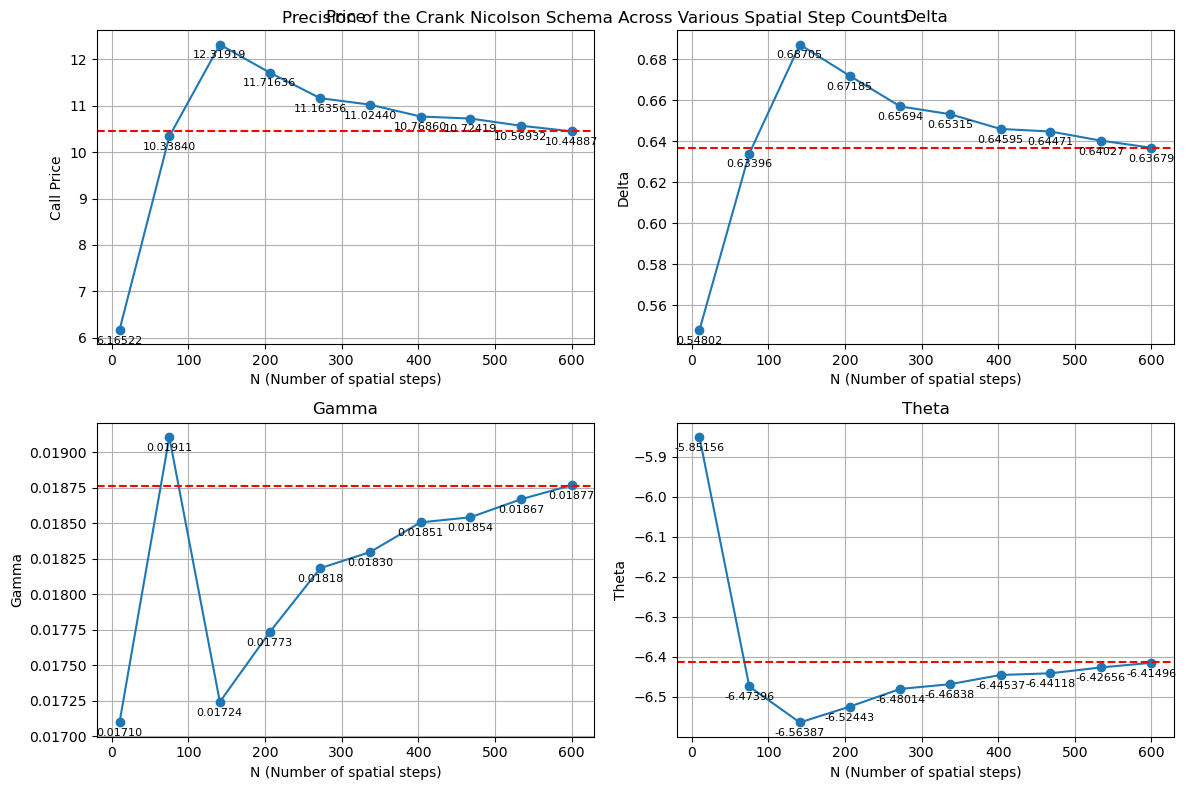

In [16]:
results = []
for N in N_values:
    results.append(crank_nicolson(S_max, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

# Plotting
plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(N_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of spatial steps)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    # Annotating data points
    for x, y in zip(N_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=8)

plt.tight_layout()
plt.suptitle("Precision of the Crank Nicolson Schema Across Various Spatial Step Counts")

plt.show()


### Plotting Crank Nicolson Schema Values for Different Time Step Discretizations

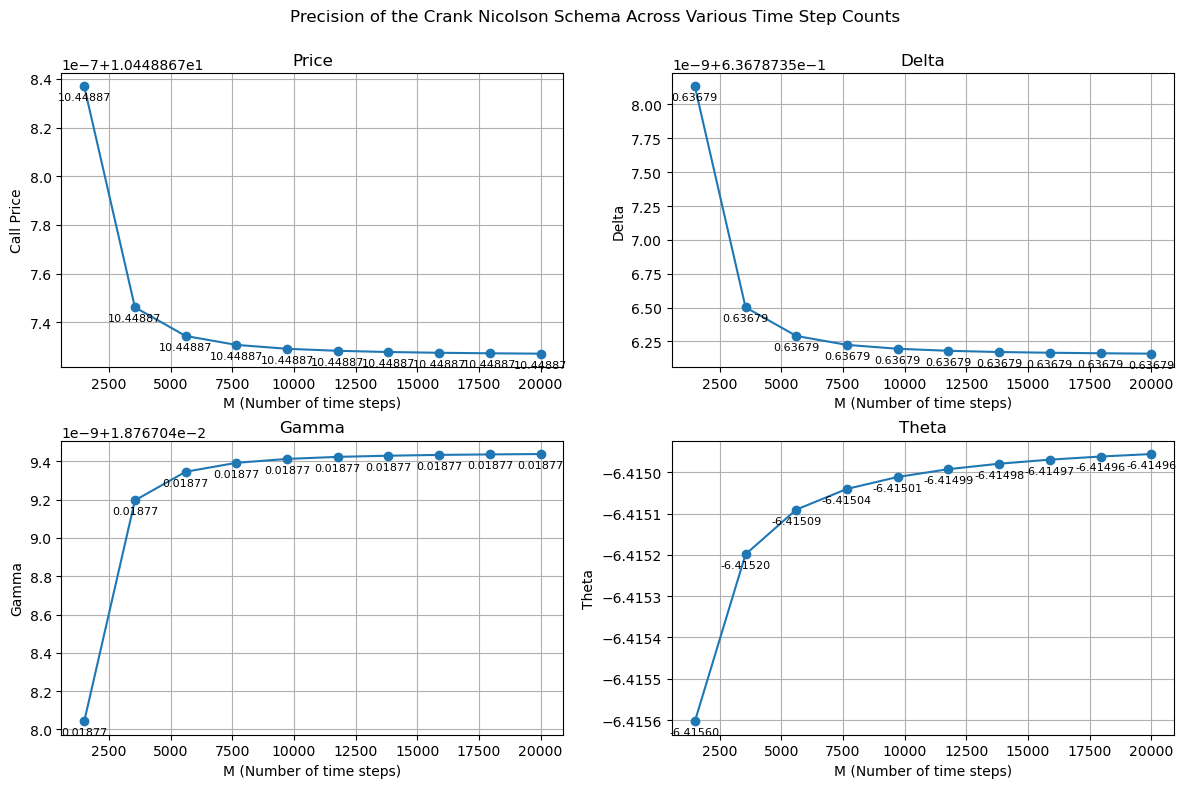

In [17]:
results = []
for M in M_values:
    results.append(crank_nicolson(S_max, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

# Plotting
plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label) in enumerate(zip(titles, data, y_labels), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(M_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('M (Number of time steps)')
    ax.set_ylabel(y_label)
    ax.grid(True)

    # Annotate only the last point
    for x, y in zip(M_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Precision of the Crank Nicolson Schema Across Various Time Step Counts")

plt.show()

# Comparing Performance

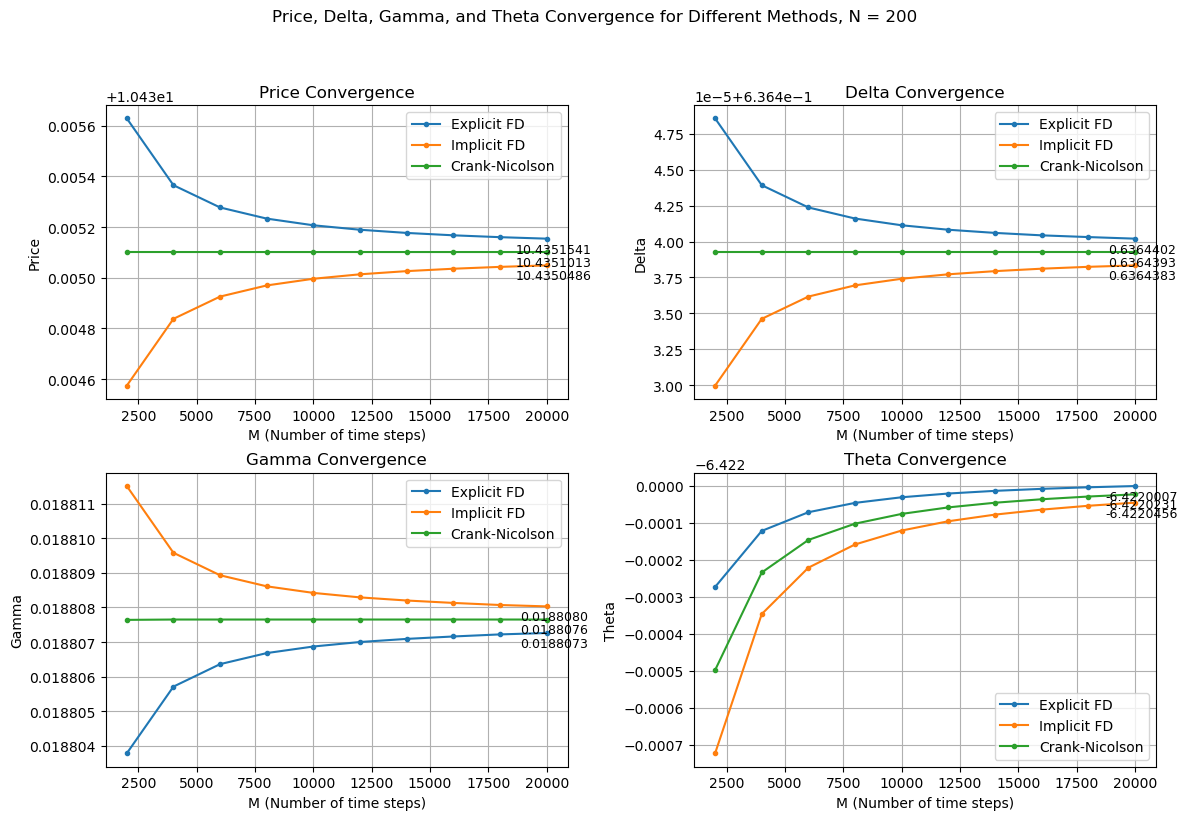

In [18]:
N = 200
M2_values = np.linspace(2000, 20000, 10, dtype= int).tolist()
results_explicit = {'price': [], 'delta': [], 'gamma': [], 'theta': []}
results_implicit = {'price': [], 'delta': [], 'gamma': [], 'theta': []}
results_crank_nicolson = {'price': [], 'delta': [], 'gamma': [], 'theta': []}
hee = 8
for M in M2_values:
    price, delta, gamma, theta = explicit_fd(S_max, K, T, r, sigma, N, M)
    results_explicit['price'].append(round(price, hee))
    results_explicit['delta'].append(round(delta, hee))
    results_explicit['gamma'].append(round(gamma, hee))
    results_explicit['theta'].append(round(theta, hee))

    price, delta, gamma, theta = implicit_fd(S_max, K, T, r, sigma, N, M)
    results_implicit['price'].append(round(price, hee))
    results_implicit['delta'].append(round(delta, hee))
    results_implicit['gamma'].append(round(gamma, hee))
    results_implicit['theta'].append(round(theta, hee))

    price, delta, gamma, theta = crank_nicolson(S_max, K, T, r, sigma, N, M)
    results_crank_nicolson['price'].append(round(price, hee))
    results_crank_nicolson['delta'].append(round(delta, hee))
    results_crank_nicolson['gamma'].append(round(gamma, hee))
    results_crank_nicolson['theta'].append(round(theta, hee))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
metrics = ['price', 'delta', 'gamma', 'theta']
titles = ['Price', 'Delta', 'Gamma', 'Theta']

def annotate_final_value(ax, x_values, y_values, label):
    final_x = x_values[-1]
    final_y = y_values[-1]
    ax.annotate(f'{final_y:.7f}', (final_x, final_y), textcoords="offset points", xytext=(5, -10), ha='center', fontsize=9)
    ax.plot(x_values, y_values, label=label, marker='.')

for ax, metric, title in zip(axs.flat, metrics, titles):
    annotate_final_value(ax, M2_values, results_explicit[metric], 'Explicit FD')
    annotate_final_value(ax, M2_values, results_implicit[metric], 'Implicit FD')
    annotate_final_value(ax, M2_values, results_crank_nicolson[metric], 'Crank-Nicolson')
    ax.set_xlabel('M (Number of time steps)')
    ax.set_ylabel(title)
    ax.set_title(f'{title} Convergence')
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.suptitle(f'Price, Delta, Gamma, and Theta Convergence for Different Methods, N = {N}', y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()

## Plotting the discrepancies of each method against the analytical price and Greek values

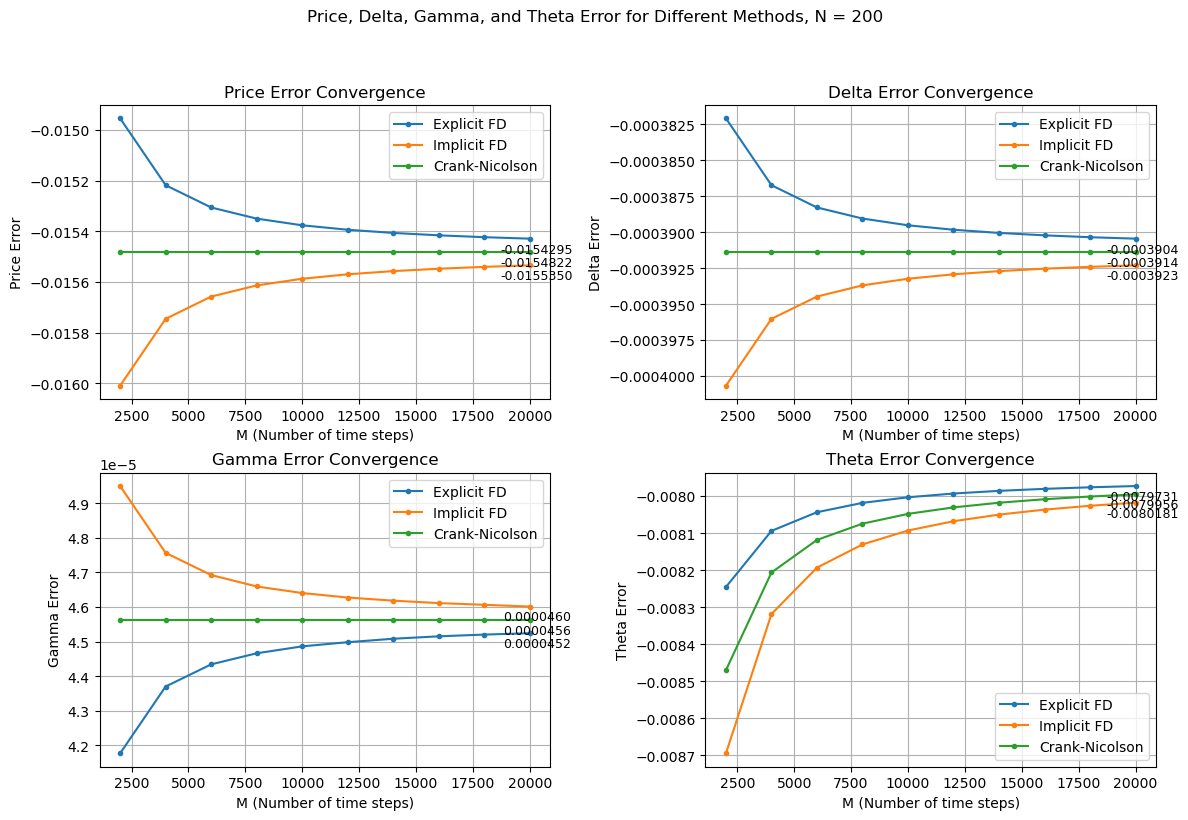

In [19]:

analytical_price, analytical_delta, analytical_gamma, analytical_theta = analytical_call(S0, sigma, T, K, r)

errors_explicit = {'price': [], 'delta': [], 'gamma': [], 'theta': []}
errors_implicit = {'price': [], 'delta': [], 'gamma': [], 'theta': []}
errors_crank_nicolson = {'price': [], 'delta': [], 'gamma': [], 'theta': []}

for M in M2_values:
    price, delta, gamma, theta = explicit_fd(S_max, K, T, r, sigma, N, M)
    errors_explicit['price'].append(round(price - analytical_price, hee))
    errors_explicit['delta'].append(round(delta - analytical_delta, hee))
    errors_explicit['gamma'].append(round(gamma - analytical_gamma, hee))
    errors_explicit['theta'].append(round(theta - analytical_theta, hee))

    price, delta, gamma, theta = implicit_fd(S_max, K, T, r, sigma, N, M)
    errors_implicit['price'].append(round(price - analytical_price, hee))
    errors_implicit['delta'].append(round(delta - analytical_delta, hee))
    errors_implicit['gamma'].append(round(gamma - analytical_gamma, hee))
    errors_implicit['theta'].append(round(theta - analytical_theta, hee))

    price, delta, gamma, theta = crank_nicolson(S_max, K, T, r, sigma, N, M)
    errors_crank_nicolson['price'].append(round(price - analytical_price, hee))
    errors_crank_nicolson['delta'].append(round(delta - analytical_delta, hee))
    errors_crank_nicolson['gamma'].append(round(gamma - analytical_gamma, hee))
    errors_crank_nicolson['theta'].append(round(theta - analytical_theta, hee))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
metrics = ['price', 'delta', 'gamma', 'theta']
titles = ['Price Error', 'Delta Error', 'Gamma Error', 'Theta Error']

def annotate_final_value(ax, x_values, y_values, label):
    final_x = x_values[-1]
    final_y = y_values[-1]
    ax.annotate(f'{final_y:.7f}', (final_x, final_y), textcoords="offset points", xytext=(5, -10), ha='center', fontsize=9)
    ax.plot(x_values, y_values, label=label, marker='.')

for ax, metric, title in zip(axs.flat, metrics, titles):
    annotate_final_value(ax, M2_values, errors_explicit[metric], 'Explicit FD')

    annotate_final_value(ax, M2_values, errors_implicit[metric], 'Implicit FD')

    annotate_final_value(ax, M2_values, errors_crank_nicolson[metric], 'Crank-Nicolson')

    ax.set_xlabel('M (Number of time steps)')
    ax.set_ylabel(title)
    ax.set_title(f'{title} Convergence')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle(f'Price, Delta, Gamma, and Theta Error for Different Methods, N = {N}', y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


## Analysis of Convergence

### Price Convergence
- The Explicit FD method and Implicit method converge more slowly compared to the Crank-Nicolson method, is stable and close to the analytical solution.
- All three methods have similar final values, which suggests that they reach an accurate solution with large time steps.
- All three methods stabilize. 

### Delta Convergence
- The Implicit FD and Explicit methods converge slower than Crank-Nicolson but remains close in value.
- Crank-Nicolson converges faster and is generally stable across all time steps.

### Gamma Convergence
- The Explicit FD method starts with a lower value and converges slower than the other two methods.
- The Implicit FD method starts higher than the others and stabilizes to a value higher than Crank-Nicolson.
- Crank-Nicolson converges to a more stable and accurate solution with a relatively flat line, indicating strong convergence.

### Theta Convergence
- The Explicit FD method converges fastest. 
- All three methodsmethods converge to similar final values, with the Explicit FD stabilizing slightly faster.
- All methods reach a stable final value.
